In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter   # 用来将网络数据发送到tensorboard中

import time
import pandas as pd
import json
from IPython.display import clear_output
import matplotlib.pyplot as plt 

from collections import OrderedDict
from collections import namedtuple
from itertools import product

class RunBuilder():
    @staticmethod          # 静态函数可以直接用类名调用，不需要创建类的实例
    def get_runs(params):
        Run = namedtuple("Run", params.keys())   # 用于构建带名字的元组，名字为"Run"
        
        runs = []
        for v in product(*params.values()):      # 对于所有超参数的组合
            runs.append(Run(*v))                 # 构建一个带名元组
        
        return runs
    
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_strat_time = None
        
        self.network = None
        self.loader = None
        self.tb = None       # summarywriter
        
    def begin_run(self, run, network, loader):        # 每次运行开始调用
        self.run_start_time = time.time()
        
        self.run_params = run      # run代表所有超参数的元组
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')    # 为本次运行起名
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('image', grid)
        # self.tb.add_graph(self.network, images)
        self.tb.add_graph(
            self.network,
            images.to(getattr(run, 'device', 'cpu'))
        )
        
    def end_run(self):           # 每次运行结束调用
        self.tb.close()
        self.epoch_count = 0     # 初始化epoch计数
        
    def begin_epoch(self):         # 每个epoch开始时
        self.epoch_start_time = time.time()  # 设置开始时间
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        results = OrderedDict()            # 有序字典存放运行结果
        # 把需要的数据加入字典
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        for k, v in self.run_params._asdict().items(): # 对于本次运行的所有超参数，转换成字典，并提取键值
            results[k] = v         # 加入results
            
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')  # 利用pandas将结果格式化输出
        
        clear_output(wait=True)    # 清空Jupyter notebook当前输出
        display(df)                # 在Jupyter notebook中输出结果

    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):

        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)     # Linear = fully connected(fc) = dense
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)                   # 卷积层中不包含激活函数，需要手动添加
        t = F.max_pool2d(t, kernel_size=2, stride=2)     # 池化操作（没有权重的函数不能称为层）
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)       # 必须手动flatten
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        # t = F.softmax(t, dim=1)           # 不直接在forward中用softmax，而是在训练过程中用cross-entropy损失函数计算loss，其中自带softmax
        
        return t
    
    
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

## Easy way

In [5]:
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)    # 一次读入全部图像
data = next(iter(loader))
data[0].mean(), data[0].std()    # 求所有图像所有像素的均值和标准差

(tensor(0.2860), tensor(0.3530))

## Hard Way (手算)

In [3]:
loader = DataLoader(train_set, batch_size=1000, num_workers=1)  # 一批一批的读入
num_of_pixels = len(train_set) * 28 * 28    # 所有图像的像素总数

total_sum = 0       # 所有图像的像素值之和
for batch in loader: total_sum += batch[0].sum()    # 计算像素和

# 算均值
mean = total_sum / num_of_pixels

# 算标准差
sum_of_squared_error = 0
for batch in loader:
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_of_pixels)

mean, std

(tensor(0.2860), tensor(0.3530))

## Plotting the Values

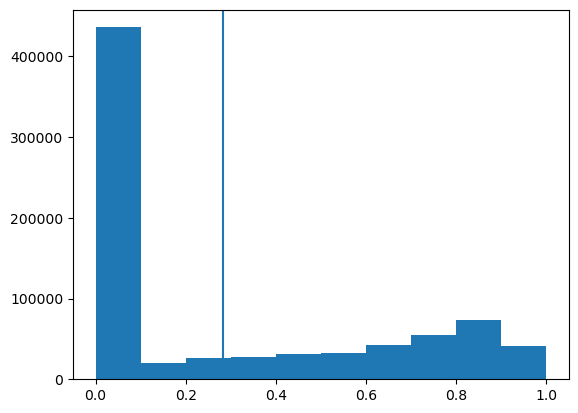

In [3]:
loader = DataLoader(train_set, batch_size=1000, num_workers=1)    # 一次读入全部图像
data = next(iter(loader))
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())

## Using the mean and std values

In [ ]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

# Batch Norm

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

from torch.utils.tensorboard import SummaryWriter   # 用来将网络数据发送到tensorboard中

import matplotlib.pyplot as plt 
import math
import time
import pandas as pd
import json
from IPython.display import clear_output

from collections import OrderedDict
from collections import namedtuple
from itertools import product

class RunBuilder():
    @staticmethod          # 静态函数可以直接用类名调用，不需要创建类的实例
    def get_runs(params):
        Run = namedtuple("Run", params.keys())   # 用于构建带名字的元组，名字为"Run"
        
        runs = []
        for v in product(*params.values()):      # 对于所有超参数的组合
            runs.append(Run(*v))                 # 构建一个带名元组
        
        return runs
class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_strat_time = None
        
        self.network = None
        self.loader = None
        self.tb = None       # summarywriter
        
    def begin_run(self, run, network, loader):        # 每次运行开始调用
        self.run_start_time = time.time()
        
        self.run_params = run      # run代表所有超参数的元组
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')    # 为本次运行起名
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('image', grid)
        self.tb.add_graph(self.network, images)
        
    def end_run(self):           # 每次运行结束调用
        self.tb.close()
        self.epoch_count = 0     # 初始化epoch计数
        
    def begin_epoch(self):         # 每个epoch开始时
        self.epoch_start_time = time.time()  # 设置开始时间
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        results = OrderedDict()            # 有序字典存放运行结果
        # 把需要的数据加入字典
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        for k, v in self.run_params._asdict().items(): # 对于本次运行的所有超参数，转换成字典，并提取键值
            results[k] = v         # 加入results
            
        self.run_data.append(results)   # 加入run_data列表
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')  # 利用pandas将结果格式化输出
        
        clear_output(wait=True)    # 清空Jupyter notebook当前输出
        display(df)                # 在Jupyter notebook中输出结果

    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName):

        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [11]:
torch.manual_seed(50)
network1 = nn.Sequential(           # 没有BatchNorm
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60, out_features=10)
)

In [12]:
torch.manual_seed(50)
network2 = nn.Sequential(           # 有BatchNorm
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(6),  # 6为上一层的输出通道数
    nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4, out_features=120),
    nn.ReLU(),
    nn.BatchNorm1d(120), # 120为上一层的输出
    nn.Linear(in_features=120, out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60, out_features=10)
)

In [9]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)    # 一次读入全部图像
data = next(iter(loader))
mean = data[0].mean()
std = data[0].std()    # 求所有图像所有像素的均值和标准差

train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

In [14]:
trainsets = {
    'not_normal':train_set,
    'normal': train_set_normal
}
networks = {
    "no_batch_norm": network1,
    "batch_norm": network2
}

In [15]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [1000],
    shuffle=[True],
    num_workers = [1],
    device = ['cpu'],
    train_set = ['normal', 'not_normal'],
    network = list(networks.keys())     # 和上面手写train_set列表效果一样，但可以动态变化                 
)

m = RunManager()
for run in RunBuilder.get_runs(params):

    device = torch.device(run.device)
    network = networks[run.network].to(device)
    loader = DataLoader(trainsets[run.train_set], batch_size=run.batch_size, shuffle=run.shuffle, num_workers=run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr = run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch()
        for batch in loader:
            images, labels = batch      # get batch
            preds = network(images)     # pass batch
            loss = F.cross_entropy(preds, labels)   # caculate loss
            optimizer.zero_grad()       # zero gradients
            loss.backward()             # calculate gradients
            optimizer.step()            # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()
m.save("results")

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle,num_workers,device,train_set,network
0,1,1,0.906163,0.656350,16.917409,20.522625,0.01,1000,True,1,cpu,normal,no_batch_norm
1,1,2,0.478183,0.820067,23.543191,44.183226,0.01,1000,True,1,cpu,normal,no_batch_norm
2,1,3,0.401715,0.852017,17.679706,61.940129,0.01,1000,True,1,cpu,normal,no_batch_norm
3,1,4,0.353065,0.870400,17.450009,79.476841,0.01,1000,True,1,cpu,normal,no_batch_norm
4,1,5,0.324558,0.879450,17.428647,96.989269,0.01,1000,True,1,cpu,normal,no_batch_norm
5,2,1,0.584009,0.787333,20.444985,26.389428,0.01,1000,True,1,cpu,normal,batch_norm
6,2,2,0.344745,0.872417,17.025568,43.538210,0.01,1000,True,1,cpu,normal,batch_norm
7,2,3,0.306971,0.885883,19.185883,62.826512,0.01,1000,True,1,cpu,normal,batch_norm
8,2,4,0.281029,0.894917,27.317093,90.360705,0.01,1000,True,1,cpu,normal,batch_norm
9,2,5,0.265725,0.899233,30.102407,120.601357,0.01,1000,True,1,cpu,normal,batch_norm


In [16]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False) # 将输出按准确率降序排列

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,shuffle,num_workers,device,train_set,network
19,4,5,0.238590,0.910067,18.124465,88.058664,0.01,1000,True,1,cpu,not_normal,batch_norm
18,4,4,0.250828,0.906000,14.798220,69.806093,0.01,1000,True,1,cpu,not_normal,batch_norm
17,4,3,0.262104,0.901683,19.545286,54.865579,0.01,1000,True,1,cpu,not_normal,batch_norm
14,3,5,0.266972,0.901283,15.554151,80.846552,0.01,1000,True,1,cpu,not_normal,no_batch_norm
9,2,5,0.265725,0.899233,30.102407,120.601357,0.01,1000,True,1,cpu,normal,batch_norm
13,3,4,0.280509,0.896833,18.100440,65.181212,0.01,1000,True,1,cpu,not_normal,no_batch_norm
16,4,2,0.279871,0.896233,13.741382,35.134885,0.01,1000,True,1,cpu,not_normal,batch_norm
8,2,4,0.281029,0.894917,27.317093,90.360705,0.01,1000,True,1,cpu,normal,batch_norm
12,3,3,0.297950,0.889783,14.588526,46.979264,0.01,1000,True,1,cpu,not_normal,no_batch_norm
7,2,3,0.306971,0.885883,19.185883,62.826512,0.01,1000,True,1,cpu,normal,batch_norm
